In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from seqeval.metrics import classification_report,accuracy_score,f1_score
from seqeval.scheme import IOB2

from dataload import lang, localdata
from tagger.charbilstm import CharBiLSTM
from etc.customUtil import showGraph, showParallel
from etc import defaultsetting as ds

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = ds.TOKKEN_PAD_IDX
tag_UNK = ds.TOKKEN_UNK_IDX

datasets, engdict, posdict = localdata.load_kor_ner(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

14096
1446
23
13
245
4
245
250
500
4250


In [5]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(engdict, device, x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [7]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(engdict, device, x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    global engdict
    global posdict
    global device
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    
    y_train_true = []
    y_train_pred = []    
        
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(engdict, device, x_train)

        __tagged, tagged = torch.max(o, dim=-1)
        y_train = y_train.tolist()
        tagged = tagged.tolist()
        for i in range(len(y_train)):
            l = y_train[i]
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i][:seq_len]
            _p = tagged[i][:seq_len]

            if _y == _p:
                cnt_corr_samples +=1
            
            y_train_true.append(posdict.sentenceFromIndexes(_y))
            y_train_pred.append(posdict.sentenceFromIndexes(_p))
        
    return (cnt_corr_samples / total_samples,
            accuracy_score(y_train_true, y_train_pred),
            f1_score(y_train_true, y_train_pred, mode='strict', scheme=IOB2))

In [9]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_ner.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(engdict, device, input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [11]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq]).view(-1).tolist())
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = CharBiLSTM(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

2 epoch Dev F1 score: 0.0 -> 0.0269058
3 epoch Dev F1 score: 0.0269058 -> 0.176471
4 epoch Dev F1 score: 0.176471 -> 0.334372
5 epoch Dev F1 score: 0.334372 -> 0.477064
6 epoch Dev F1 score: 0.477064 -> 0.565333
7 epoch Dev F1 score: 0.565333 -> 0.678541
8 epoch Dev F1 score: 0.678541 -> 0.703189
9 epoch Dev F1 score: 0.703189 -> 0.71381
10 epoch Dev F1 score: 0.71381 -> 0.750427
11 epoch Dev F1 score: 0.750427 -> 0.775041
14 epoch Dev F1 score: 0.775041 -> 0.783607
20 epoch Dev F1 score: 0.783607 -> 0.78943
22 epoch Dev F1 score: 0.78943 -> 0.796148
60
	580.4154722690582


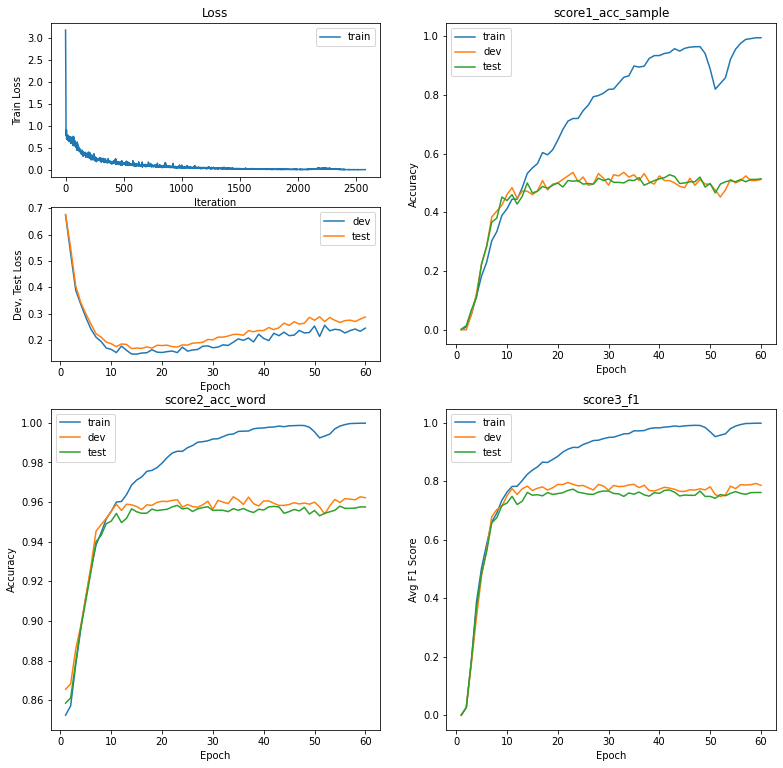

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.0   0.000   0.0
0.026902   0.02691   0.026201
0.1867   0.1765   0.18815
0.38719   0.3344   0.3685
0.50382   0.4771   0.48553
0.5847   0.5653   0.55937
0.66058   0.6785   0.65787
0.69118   0.7032   0.67511
0.73492   0.7138   0.71718
0.76282   0.7504   0.72543
0.78229   0.775   0.74868
0.78304   0.7552   0.72068
0.80255   0.7743   0.73191
0.82401   0.7836   0.76194
0.83804   0.7685   0.75251
0.84926   0.7762   0.75419
0.86555   0.7808   0.7503
0.86431   0.7701   0.76167
0.87458   0.778   0.75497
0.88546   0.7894   0.75803
0.90016   0.7889   0.76087
0.90982   0.7961   0.76868
0.91609   0.7896   0.77304
0.9156   0.7844   0.76287
0.92604   0.7858   0.75967
0.93208   0.7779   0.75591
0.93943   0.7703   0.75531
0.94052   0.7893   0.76342
0.94599   0.7839   0.76687
0.95008   0.7695   0.76664
0.95107   0.7858   0.7584
0.95649   0.7819   0.75704
0.96221   0.7829   0.7484
0.96313   0.7876   0.76019
0.97269   0.7897   0.75582
0.9726   0.7783   0.76314
0.97362   0.7866   0.75373
0.98016   0.7685 

In [16]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 16
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
맨시티                 B-OG    B-OG
의                   O       O
스벤                  O       B-PS
예란                  B-PS    I-PS
에릭손                 B-PS    I-PS
감독                  O       O
은                   O       O
8                   B-DT    B-DT
일                   I-DT    I-DT
현지                  O       O
언론                  O       O
과                   O       O
의                   O       O
인터뷰                 O       O
에서                  O       O
호나우지뉴               B-PS    B-PS
영입                  O       O
가능                  O       O
성                   O       O
에                   O       O
대해                  O       O
"                   O       O
호나우지뉴               B-PS    B-PS
의                   O       O
영입설                 O       O
은                   O       O
처음                  O       O
들                   O       O
어                   O       O
보                   O       O
는                   O       O
이야기       

In [17]:
# sen = 'I am your father .'
# # in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

# # sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
# #         4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
# #          116, 4616, 4617,   17]
# # in_sen = torch.tensor(sen2, device=device)

# calc(model, sen)

In [18]:
best_model = torch.load('best_char_bilstm_ner.pt')
s_dev = scores(best_model, datasets['dev'], 100)
s_test = scores(best_model, datasets['test'], 100)
print(s_dev)
print(s_test)

(0.524, 0.9608663181478716, 0.7961476725521669)
(0.508, 0.9575830633617117, 0.7686832740213524)
